In [64]:
# Data Extraction
import gzip
import json

# Utility
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

# Dictionary
from collections import defaultdict

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Date Time
from datetime import datetime
import time

import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Reco Final Project/renttherunway_final_data.json.gz'
# path_mod_cloth = 

In [4]:
data2 = []
with gzip.open(path) as file:
    for line in file:
        row_data = json.loads(line)
        data2.append(row_data) 

In [5]:
data2[4]

{'age': '27',
 'body type': 'athletic',
 'bust size': '34b',
 'category': 'gown',
 'fit': 'fit',
 'height': '5\' 9"',
 'item_id': '616682',
 'rating': '10',
 'rented for': 'wedding',
 'review_date': 'September 26, 2016',
 'review_summary': 'Was in love with this dress !!!',
 'review_text': "I have always been petite in my upper body and extremely athletic. \nI'm 5'9 and typically am a size 4,6,8 due to the fact I had a smaller upper frame and 34B cup. Depends what fabric were talking about too! \nHowever, because I have been lifting weights my back has grown (odd to add- but figured I'd say it knowing other people lift weights) My lat area is so wide that I was suffocating in a size 6. If I wasn't as muscular in my back I would've been fine. I would recommend to go up a size if you are into lifting weights and very broad in your upper body. ",
 'size': 12,
 'user_id': '151944',
 'weight': '145lbs'}

In [6]:
# Convert to dataframe
df = pd.DataFrame(data2)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


# <b> Exploratory Data Analysis </b>

*Objective of Exploratory Analysis is to remove data rows that have NAs, remove any outliers and clean data for modelling purposes.*

In [7]:
df.shape

(192544, 15)

In [8]:
# Check which columns have NAN values
df.isna().any()

fit               False
user_id           False
bust size          True
item_id           False
weight             True
rating             True
rented for         True
review_text       False
body type          True
review_summary    False
category          False
height             True
size              False
age                True
review_date       False
dtype: bool

*We can see that ratings columns along with others has NA values. For our model fitting, we will remove all NAs from our dataframe.*

In [9]:
# Dropping all NAs
df.dropna(inplace= True)
df = df.reset_index(drop = True)
df.shape

(146381, 15)

10    94291
8     40761
6      8341
4      2205
2       783
Name: rating, dtype: int64




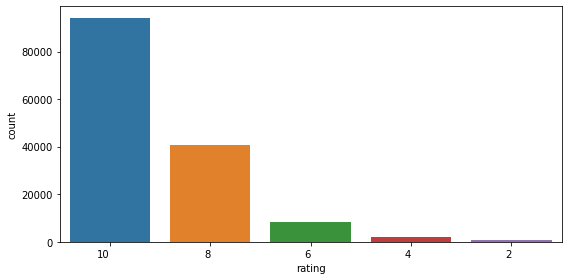

In [10]:
# Check distribution of data for each type

## ratings
print(df['rating'].value_counts(dropna=False))
print("")
print("")
plt.figure(figsize=(8,4))
ax = sns.countplot(x="rating", data=df, order = df['rating'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.tight_layout()
plt.show()

*We can see that there are a majority of ratings that are under '10' category and very few ratings that are negative.*

In [11]:
# Before proceeding forward we will convert numeric strings to numeric

# Weight
df['weight'] = df['weight'].str.replace('lbs', '')
df['weight'] = df['weight'].astype('int')

# Rating
df['rating'] = df['rating'].astype('int')

# Height
df['hgt'] = 1
for i in range(df.shape[0]):
    df['hgt'][i] = int(df['height'][i].split('\' ')[0])*12 + int(df['height'][i].split('\' ')[1].split("\"")[0])
df['hgt'] = df['hgt'].astype('int')
df.drop(columns = ['height'], inplace=True)

# Age
df['age'] = df['age'].astype('int')

# Time
df['ut'] = 1
for i in range(df.shape[0]):
    df['ut'][i] = time.mktime(time.strptime(df['review_date'][i], '%B %d, %Y'))
df['ut'] = df['ut'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,size,age,review_date,hgt,ut
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,14,28,"April 20, 2016",68,1461110400
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,12,36,"June 18, 2013",66,1371513600
2,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,8,34,"February 12, 2014",65,1392163200
3,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,12,27,"September 26, 2016",69,1474848000
4,fit,734848,32b,364092,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,8,45,"April 30, 2016",68,1461974400


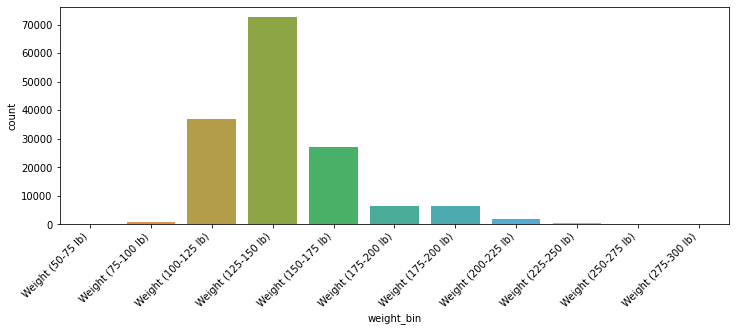

Weight (50-75 lb)          7
Weight (275-300 lb)       29
Weight (250-275 lb)      205
Weight (225-250 lb)      476
Weight (75-100 lb)       647
Weight (200-225 lb)     1892
Weight (175-200 lb)     6373
Weight (150-175 lb)    27172
Weight (100-125 lb)    37021
Weight (125-150 lb)    72559
Name: weight_bin, dtype: int64

In [13]:
def binning_operation(value):
    if value >= 50 and value < 75:
        column_value = 'Weight (50-75 lb)'
    elif value >= 75 and value < 100:
        column_value = 'Weight (75-100 lb)'
    elif value >= 100 and value < 125:
        column_value = 'Weight (100-125 lb)'
    elif value >= 125 and value < 150:
        column_value = 'Weight (125-150 lb)'
    elif value >= 150 and value < 175:
        column_value = 'Weight (150-175 lb)'
    elif value >= 175 and value < 200:
        column_value = 'Weight (175-200 lb)'
    elif value >= 200 and value < 225:
        column_value = 'Weight (200-225 lb)'
    elif value >= 225 and value < 250:
        column_value = 'Weight (225-250 lb)'
    elif value >= 250 and value < 275:
        column_value = 'Weight (250-275 lb)'
    elif value >= 275 and value <= 300:
        column_value = 'Weight (275-300 lb)'
    
    return column_value


df['weight_bin'] = df['weight'].apply(binning_operation)
order_list = ['Weight (50-75 lb)', 'Weight (75-100 lb)', 'Weight (100-125 lb)', 'Weight (125-150 lb)',
              'Weight (150-175 lb)', 'Weight (175-200 lb)', 'Weight (175-200 lb)', 'Weight (200-225 lb)',
              'Weight (225-250 lb)', 'Weight (250-275 lb)', 'Weight (275-300 lb)']

# Plot the distribution
plt.figure(figsize=(12,4))
ax = sns.countplot(x="weight_bin", data=df, order = order_list)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

# Print the count
df['weight_bin'].value_counts(ascending = True)

*Based on the above chart we can see that very few apparel has bene rented for weight less than 100 lbs and more than 250 lbs. All these observations can be removed because they have very less variablility and will not contribute to variations in ratings.*

In [14]:
# Filtering data on weights
df = df[np.logical_and(df.weight >= 100, df.weight <= 200)]

<Figure size 1440x1440 with 0 Axes>

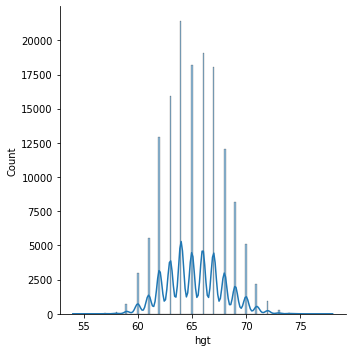

In [15]:
# Plot distribution for height
plt.figure(figsize=(20,20))
sns.displot(df['hgt'], kde=True)

*Height is in acceptable range of values with significant count, hence all data is kept*

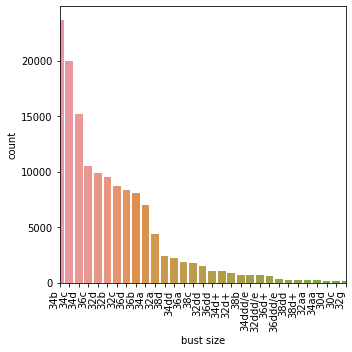

Number of Unique Categories for Bust Size: 91


In [16]:
# Distribution plot for Bust size
# print(df['bust size'].value_counts(dropna=False))
plt.figure(figsize=(5,5))
ax = sns.countplot(x="bust size", data=df, order = df['bust size'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_xlim(left = 0, right = 30)
plt.tight_layout()
plt.show()

# Total categories
print('Number of Unique Categories for Bust Size:', len(set(df['bust size'])))

*As we can see from above graph, there are 91 categories under Bust Size and performing One-Hot Encolding*

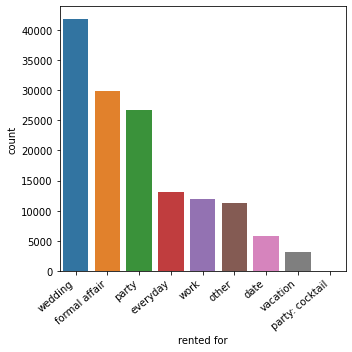

wedding            41844
formal affair      29856
party              26684
everyday           13155
work               12000
other              11304
date                5850
vacation            3192
party: cocktail        1
Name: rented for, dtype: int64

In [17]:
# Plot Distribution for 'rented for'

plt.figure(figsize=(5,5))
ax = sns.countplot(x="rented for", data=df, order = df['rented for'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Count Table
df['rented for'].value_counts()

*There are only 9 categories with significant amount of values under each category except 'party: cocktail'. We are filtering out the category 'party: cocktail' from our data since there is only one record for this category and it will not impact the model.* 

In [18]:
# Filtering out 'party: cocktail'
df = df[df['rented for'] != 'party: cocktail']

   rating  len_review_text
0       2        47.511229
1       4        53.088059
2       6        59.886175
3       8        63.685972
4      10        57.949272


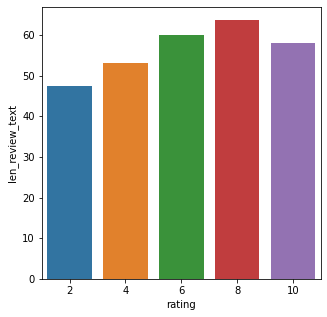

In [19]:
# Review Text Length Analysis

# Create column for length of review text
def len_review(review_text):
    length = len(review_text.split())
    return length

df['len_review_text'] = df['review_text'].apply(len_review)

# Create Bar Plot
plt.figure(figsize=(5,5))
rating_len_review = df.groupby(by = 'rating')['len_review_text'].mean().reset_index()
rating_len_review
sns.barplot(data = rating_len_review, x = 'rating', y = 'len_review_text')
print(rating_len_review)

hourglass            43216
athletic             37438
petite               18800
pear                 17682
straight & narrow    12810
full bust            10362
apple                 3577
Name: body type, dtype: int64


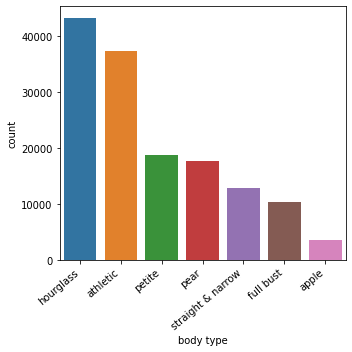

In [20]:
# Distribution plot for Body Type
print(df['body type'].value_counts(dropna=False))
plt.figure(figsize=(5,5))
ax = sns.countplot(x="body type", data=df, order = df['body type'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_xlim(left = 0, right = 50)
plt.tight_layout()
plt.show()

*For 'body type' all of the categories have sufficient number of records. Hence, we are keeping this feature.*

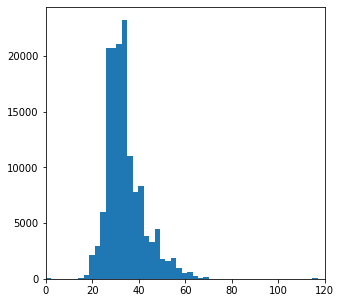

In [21]:
# Plot Distribution for Age

plt.figure(figsize = (5,5))
plt.hist(df['age'], bins = 50)
plt.xlim(0, 120)
plt.show()

*From the above graph, we can see there are clear outliers in data with ages like 0 and 117. To resolve these outliers as epr the histogram above, we have removed ages with range as 0-15 and > 80.*

In [22]:
# Filter out ages 0-15 and > 80 from df

df = df[np.logical_and(df.age > 15, df.age <= 80)]
df.shape

(143759, 18)

# <b> Ratings Prediction using Pearson Similarity

In [45]:
dataset = df.to_dict('records')

usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratingDict = {}

for d in dataset:
    user,item = d['user_id'], d['item_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingDict[(user,item)] = d['rating']

In [46]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [66]:
# Jaccard

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

# Cosine

def Cosine(i1, i2): # items
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom


# Pearson
def Pearson(i1, i2):
    # Between two items
    iBar1 = itemAverages[i1]
    iBar2 = itemAverages[i2]
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += (ratingDict[(u,i1)] - iBar1)*(ratingDict[(u,i2)] - iBar2)
    for u in inter: #usersPerItem[i1]:
        denom1 += (ratingDict[(u,i1)] - iBar1)**2
    #for u in usersPerItem[i2]:
        denom2 += (ratingDict[(u,i2)] - iBar2)**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom



def predictRating(user,item, similarity_type):
    ratings = []
    similarities = []

    if similarity_type == 'Jacard':
        for d in reviewsPerUser[user]:
            i2 = d['item_id']
            if i2 == item: continue
            ratings.append(d['rating'] - itemAverages[i2])
            similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))

    if similarity_type == 'Cosine':    
        for d in reviewsPerUser[item]:    
            i2 = d['item_id']
            if i2 == item: continue
            ratings.append(d['rating'] - itemAverages[i2])        
            similarities.append(Cosine(i2,item)) # items set

    if similarity_type == 'Pearson':    
        for d in reviewsPerUser[item]:    
            i2 = d['item_id']
            if i2 == item: continue
            ratings.append(d['rating'] - itemAverages[i2])        
            similarities.append(Pearson(i2,item)) # items set

    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [67]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for d in dataset:
    user,item = d['user_id'], d['item_id']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

ratingMean = sum([d['rating'] for d in dataset]) / len(dataset)
ratingMean

9.083132186506583

In [53]:
# Jacard
simPredictions = []
labels = []
simPredictions = [predictRating(d['user_id'], d['item_id'], 'Jaccard') for d in dataset]
labels = [d['rating'] for d in dataset]
print('MSE with Jaccard similarity is:', MSE(simPredictions, labels))

MSE with Jaccard similarity is: 2.3193757160614523


In [65]:
# Cosine
simPredictions = []
labels = []
simPredictions = [predictRating(d['user_id'], d['item_id'], 'Cosine') for d in dataset]
labels = [d['rating'] for d in dataset]
print('MSE with Cosine similarity is:', MSE(simPredictions, labels))


MSE with Cosine similarity is: 2.0719649992138947


In [68]:
# Pearson
simPredictions = []
labels = []
simPredictions = [predictRating(d['user_id'], d['item_id'], 'Pearson') for d in dataset]
labels = [d['rating'] for d in dataset]
print('MSE with Pearson similarity is:', MSE(simPredictions, labels))


MSE with Pearson similarity is: 2.0656872773022226
